In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import pymc3 as pm
import pymc3_ext as pmx
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Part I: Eight Schools

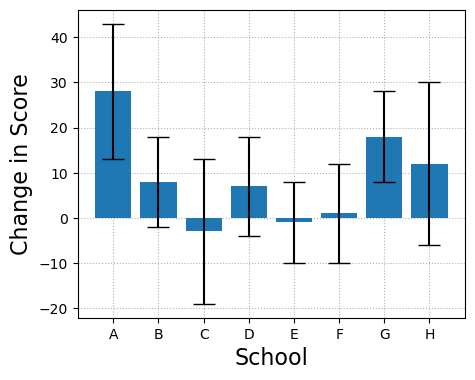

In [2]:
dscore_obs_mu = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype='float')
dscore_obs_sd = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype='float')

nschool = len(dscore_obs_mu)
labels = list('ABCDEFGH')

plt.figure(figsize=(5,4))
plt.bar(np.arange(nschool), dscore_obs_mu, yerr=dscore_obs_sd, zorder=3, capsize=8)
plt.grid(zorder=0, ls=':')
plt.xticks(np.arange(nschool), labels)
plt.xlabel("School", fontsize=16)
plt.ylabel(r"Change in Score", fontsize=16)
plt.show()

In [3]:
w = 1 / dscore_obs_sd**2

mu_pooled = np.sum(w*dscore_obs_mu)/np.sum(w)
sd_pooled = np.sum(w)**-0.5

print(f"Pooled effect size : {mu_pooled.round(1)} +/- {sd_pooled.round(1)}")

Pooled effect size : 7.7 +/- 4.1


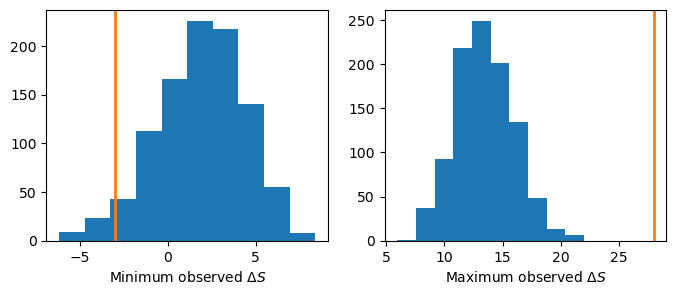

In [4]:
nboot = 1000

dscore_boot_samples = stats.norm(mu_pooled,sd_pooled).rvs(size=nboot*nschool).reshape(nboot,nschool)

fig, ax = plt.subplots(1,2, figsize=(8,3))

ax[0].hist(dscore_boot_samples.min(axis=1), color='C0')
ax[0].axvline(dscore_obs_mu.min(), color='C1', lw=2)
ax[0].set_xlabel('Minimum observed $\Delta S$')
ax[1].hist(dscore_boot_samples.max(axis=1), color='C0')
ax[1].axvline(dscore_obs_mu.max(), color='C1', lw=2)
ax[1].set_xlabel('Maximum observed $\Delta S$')

plt.show()

In [5]:
with pm.Model() as model:
    # draw population {mu,sd} hierarchically
    mu_pop = pm.Normal('mu_pop', mu=0, sd=20)
    sd_pop = pm.HalfCauchy('sd_pop', beta=2)
    
    # use off-centered parameterization
    dscore_off = pm.Normal('dscore_off', mu=0, sd=1, shape=nschool)
    dscore_mod = pm.Deterministic('dscore_mod', mu_pop + sd_pop*dscore_off)
    
    # compute the likelihood using measured dscore {mu, sd}
    lnlike = pm.Normal('lnlike', mu=dscore_mod, sd=dscore_obs_sd, observed=dscore_obs_mu)

In [6]:
with model:
    trace = pmx.sample(chains=2, tune=3000, draws=1000, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [dscore_off, sd_pop, mu_pop]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 3 seconds.


In [7]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop,7.466,4.169,-0.498,15.156,0.090,0.070,2125.0,1401.0,1.0
dscore_off[0],0.154,0.968,-1.607,1.932,0.019,0.020,2670.0,1743.0,1.0
dscore_off[1],0.013,0.972,-1.711,1.896,0.019,0.022,2496.0,1277.0,1.0
dscore_off[2],-0.085,0.968,-1.850,1.759,0.019,0.022,2597.0,1390.0,1.0
dscore_off[3],0.001,1.002,-1.876,1.886,0.020,0.023,2526.0,1376.0,1.0
dscore_off[4],-0.184,1.003,-2.065,1.693,0.020,0.023,2518.0,1505.0,1.0
dscore_off[5],-0.070,0.963,-1.820,1.812,0.020,0.022,2321.0,1454.0,1.0
dscore_off[6],0.196,0.952,-1.607,1.933,0.020,0.020,2199.0,1413.0,1.0
dscore_off[7],0.012,0.998,-1.639,2.048,0.021,0.023,2348.0,1403.0,1.0
sd_pop,2.231,2.452,0.000,6.360,0.059,0.044,1647.0,911.0,1.0


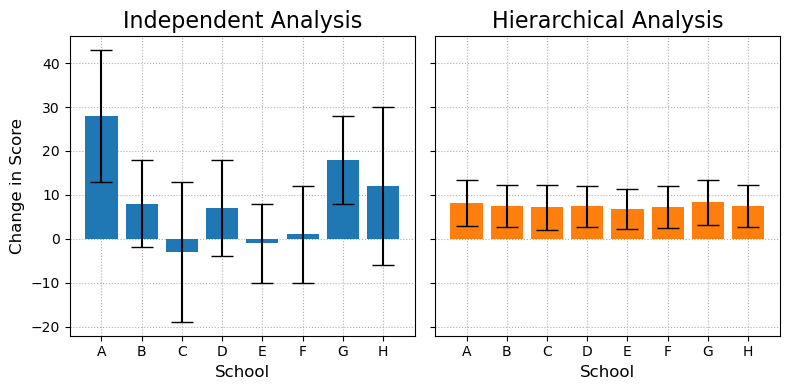

In [8]:
dscore_hbayes_mu = np.mean(np.array(trace.posterior.dscore_mod).reshape((-1,nschool)), axis=0)
dscore_hbayes_sd = np.std(np.array(trace.posterior.dscore_mod).reshape((-1,nschool)), axis=0)

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

ax[0].bar(np.arange(nschool), dscore_obs_mu, yerr=dscore_obs_sd, zorder=3, capsize=8)
ax[0].grid(zorder=0, ls=':')
ax[0].set_xticks(np.arange(nschool), labels)
ax[0].set_xlabel("School", fontsize=12)
ax[0].set_ylabel(r"Change in Score", fontsize=12)
ax[0].set_title("Independent Analysis", fontsize=16)

ax[1].bar(np.arange(nschool), dscore_hbayes_mu, yerr=dscore_hbayes_sd, color='C1', zorder=3, capsize=8)
ax[1].grid(zorder=0, ls=':')
ax[1].set_xlabel("School", fontsize=12)
ax[1].set_title("Hierarchical Analysis", fontsize=16)

plt.tight_layout()
plt.show()

In [9]:
mu_hbayes = np.mean(trace.posterior.mu_pop.values)
sd_hbayes = np.std(trace.posterior.mu_pop.values)

print(f"Pooled effect size : {mu_pooled.round(1)} +/- {sd_pooled.round(1)}")
print(f"HBayes effect size : {mu_hbayes.round(1)} +/- {sd_hbayes.round(1)}")

Pooled effect size : 7.7 +/- 4.1
HBayes effect size : 7.5 +/- 4.2


# Part II: Linear Regression

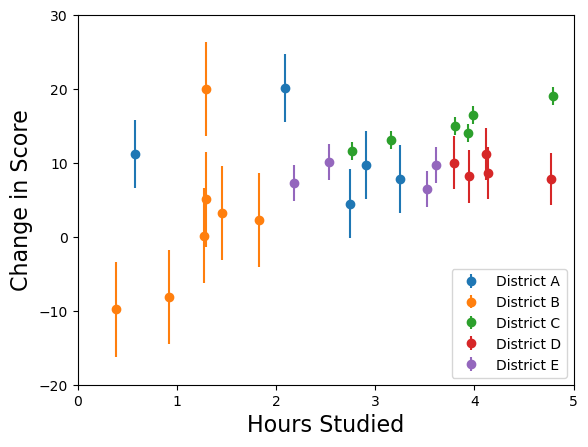

In [10]:
np.random.seed(123)

ngroups = 5
labels = list('ABCDE')

m_pop = (2.1, 1.5)
b_pop = (6.6, 2.8)

m_true = np.abs(np.random.normal(m_pop[0],m_pop[1],ngroups))
b_true = np.abs(np.random.normal(b_pop[0],b_pop[1],ngroups))

x_obs = [None]*ngroups
y_obs = [None]*ngroups
y_err = [None]*ngroups

plt.figure()
for i in range(ngroups):
    n = np.random.randint(2,8)
    xlim = np.sort(np.random.uniform(0,5,2)) + np.array([-1,1])
    
    x_obs[i] = np.random.uniform(xlim[0],xlim[1],n)
    y_obs[i] = m_true[i]*x_obs[i] + b_true[i] + np.abs(b_true[i]-b_pop[0])*np.random.normal(0,1,n)
    y_err[i] = np.abs(b_true[i]-b_pop[0])*np.ones(n)
    
    plt.errorbar(x_obs[i], y_obs[i], yerr=y_err[i], fmt='o', color=f'C{i}', label=f'District {labels[i]}')
    #plt.plot(x_obs[i], b_true[i] + m_true[i]*x_obs[i], ls=':', color=f'C{i}')
    
plt.xlim(0,5)
plt.ylim(-20,30)
plt.xlabel("Hours Studied", fontsize=16)
plt.ylabel("Change in Score", fontsize=16)
plt.legend()
plt.show()

In [11]:
import pandas as pd

district = []
for i in range(ngroups):
    for j in range(len(x_obs[i])):
        district.append(labels[i])
        
        
data = {"district": district,
        "hours_studied": np.hstack(x_obs).round(1),
        "score_change": np.array(np.hstack(y_obs), dtype='int'),
        "score_change_err": np.array(np.hstack(y_err), dtype='int')
       }

data = pd.DataFrame(data)

data.to_csv("five_districts.csv")

In [12]:
data

,district,hours_studied,score_change,score_change_err
0,A,2.7,4,4
1,A,2.9,9,4
2,A,2.1,20,4
3,A,0.6,11,4
4,A,3.3,7,4
5,B,0.9,-8,6
6,B,1.8,2,6
7,B,0.4,-9,6
8,B,1.3,19,6
9,B,1.3,5,6


## Pooled model

In [13]:
x_pooled = np.hstack(x_obs)
y_pooled = np.hstack(y_obs)
yerr_pooled = np.hstack(y_err)

x_pred = np.linspace(0,5)

In [14]:
with pm.Model() as model:
    m = pm.Normal('m', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    
    y_mod = pm.Deterministic('y_mod', m*x_pooled + b)
    y_pred = pm.Deterministic('y_pred', m*x_pred + b)
    
    lnlike = pm.Normal('lnlike', mu=y_mod, sd=yerr_pooled, observed=y_pooled)

In [15]:
with model:
    trace = pmx.sample(chains=2, tune=3000, draws=1000, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9604881318494692, but should be close to 0.9. Try to increase the number of tuning steps.


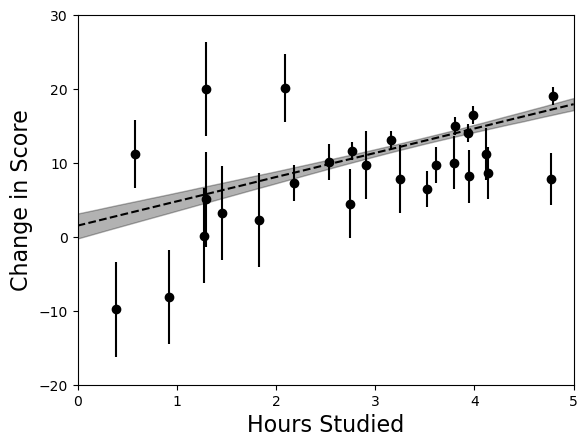

In [16]:
x_ = x_pred
y_ = np.percentile(trace.posterior.y_pred, [16,50,84], axis=[0,1])

plt.figure()
plt.errorbar(x_pooled, y_pooled, yerr=yerr_pooled, fmt='ko')
plt.plot(x_, y_[1], 'k--')
#plt.plot(x_, m_pop[0]*x_ + b_pop[0], 'k:')
plt.fill_between(x_, y_[0], y_[2], color='k', alpha=0.3)
plt.xlabel("Hours Studied", fontsize=16)
plt.ylabel("Change in Score", fontsize=16)
plt.xlim(0,5)
plt.ylim(-20,30)
plt.show()

In [17]:
pm.summary(trace, var_names=['m', 'b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,3.294,0.472,2.376,4.133,0.013,0.010,1242.0,1123.0,1.0
b,1.490,1.703,-1.550,4.783,0.048,0.037,1256.0,1090.0,1.0


## Independent model

In [18]:
x_pred = [None]*ngroups

for i in range(ngroups):
    x_pred[i] = np.linspace(x_obs[i].min(), x_obs[i].max())

In [19]:
with pm.Model() as model:
    m = pm.Normal('m', mu=0, sd=10, shape=5)
    b = pm.Normal('b', mu=0, sd=10, shape=5)

    y_mod = [None]*ngroups
    y_pred = [None]*ngroups
    lnlike = [None]*ngroups
    
    for i in range(ngroups):
        y_mod[i] = pm.Deterministic(f'y_mod_{i}', m[i]*x_obs[i] + b[i])
        y_pred[i] = pm.Deterministic(f'y_pred_{i}', m[i]*x_pred[i] + b[i])

        lnlike[i] = pm.Normal(f'lnlike_{i}', mu=y_mod[i], sd=y_err[i], observed=y_obs[i])

In [20]:
with model:
    trace = pmx.sample(chains=2, tune=3000, draws=1000, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 3 seconds.


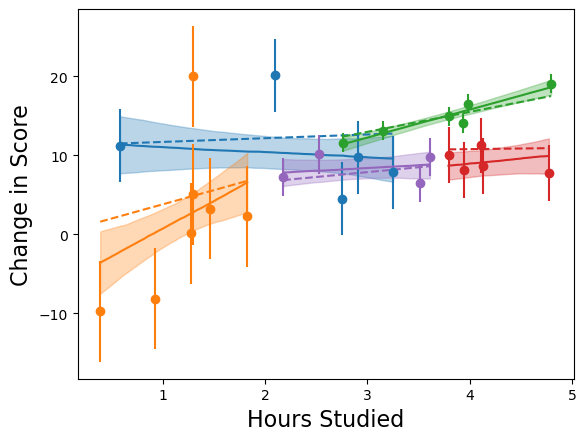

In [21]:
plt.figure()
for i in range(ngroups):
    x_ = x_pred[i]
    y_ = np.percentile(trace.posterior[f'y_pred_{i}'], [16,50,84], axis=[0,1])
    
    plt.errorbar(x_obs[i], y_obs[i], yerr=y_err[i], fmt='o', color=f'C{i}')
    plt.plot(x_, y_[1], ls='-', color=f'C{i}')
    plt.fill_between(x_, y_[0], y_[2], color=f'C{i}', alpha=0.3)
    plt.plot(x_, m_true[i]*x_ + b_true[i],  color=f'C{i}', ls='--')
    
plt.xlabel("Hours Studied", fontsize=16)
plt.ylabel("Change in Score", fontsize=16)
plt.show()

## Hierarchical model

In [22]:
x_pred = [None]*ngroups

for i in range(ngroups):
    x_pred[i] = np.linspace(x_obs[i].min(), x_obs[i].max())

In [23]:
with pm.Model() as model:
    # population hyperparameters
    m_pop_mu = pm.Normal('m_pop_mu', mu=0, sd=10)
    m_pop_sd = pm.HalfCauchy('m_pop_sd', beta=2)
    
    b_pop_mu = pm.Normal('b_pop_mu', mu=0, sd=10)
    b_pop_sd = pm.HalfCauchy('b_pop_sd', beta=2)
    
    # use off-centered parameterization
    m_off = pm.Normal('m_off', mu=0, sd=1, shape=5)
    b_off = pm.Normal('b_off', mu=0, sd=1, shape=5)

    m = pm.Deterministic('m', m_pop_mu + m_pop_sd*m_off)
    b = pm.Deterministic('b', b_pop_mu + b_pop_sd*b_off)
    
    # compute model prediction and likelihood
    y_mod = [None]*ngroups
    y_pred = [None]*ngroups
    lnlike = [None]*ngroups
    
    for i in range(ngroups):
        y_mod[i] = pm.Deterministic(f'y_mod_{i}', m[i]*x_obs[i] + b[i])
        y_pred[i] = pm.Deterministic(f'y_pred_{i}', m[i]*x_pred[i] + b[i])

        lnlike[i] = pm.Normal(f'lnlike_{i}', mu=y_mod[i], sd=y_err[i], observed=y_obs[i])

In [24]:
with model:
    trace = pmx.sample(chains=2, tune=3000, draws=1000, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b_off, m_off, b_pop_sd, b_pop_mu, m_pop_sd, m_pop_mu]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 9 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


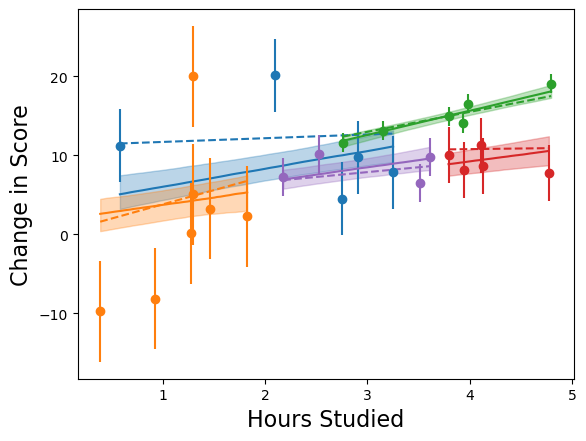

In [25]:
plt.figure()
for i in range(ngroups):
    x_ = x_pred[i]
    y_ = np.percentile(trace.posterior[f'y_pred_{i}'], [16,50,84], axis=[0,1])
    
    plt.errorbar(x_obs[i], y_obs[i], yerr=y_err[i], fmt='o', color=f'C{i}')
    plt.plot(x_, y_[1], ls='-', color=f'C{i}')
    plt.fill_between(x_, y_[0], y_[2], color=f'C{i}', alpha=0.3)
    plt.plot(x_, m_true[i]*x_ + b_true[i],  color=f'C{i}', ls='--')
    
plt.xlabel("Hours Studied", fontsize=16)
plt.ylabel("Change in Score", fontsize=16)
plt.show()

In [26]:
pm.summary(trace, var_names=['m_pop_mu', 'm_pop_sd', 'b_pop_mu', 'b_pop_sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_pop_mu,2.124,0.932,0.156,3.690,0.045,0.032,525.0,233.0,1.00
m_pop_sd,1.095,0.640,0.121,2.302,0.037,0.028,345.0,318.0,1.00
b_pop_mu,2.847,2.265,-1.145,7.350,0.068,0.059,1123.0,584.0,1.00
b_pop_sd,1.830,1.527,0.003,4.675,0.072,0.051,416.0,555.0,1.01


## Dyson Spheres

In [31]:
from astropy.timeseries import LombScargle

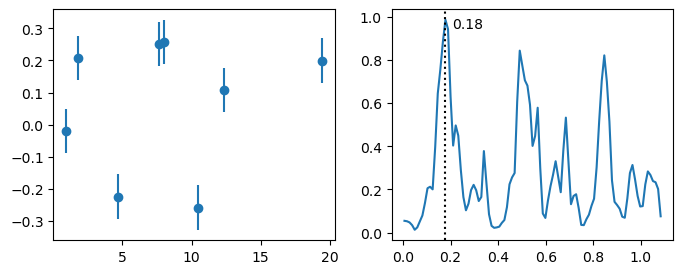

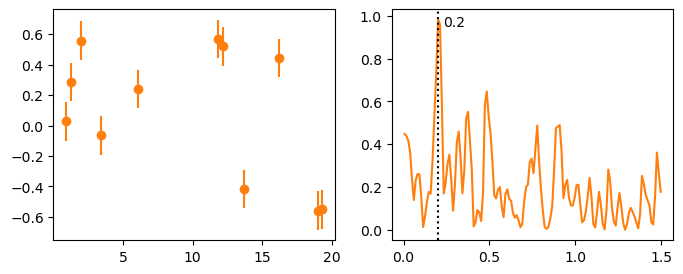

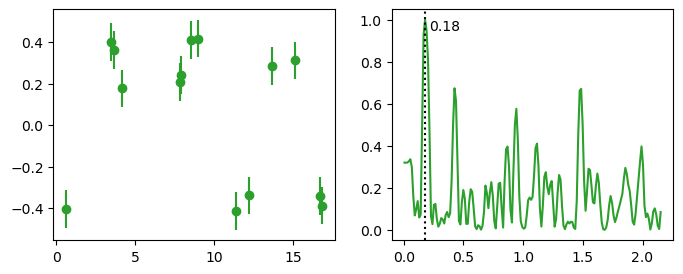

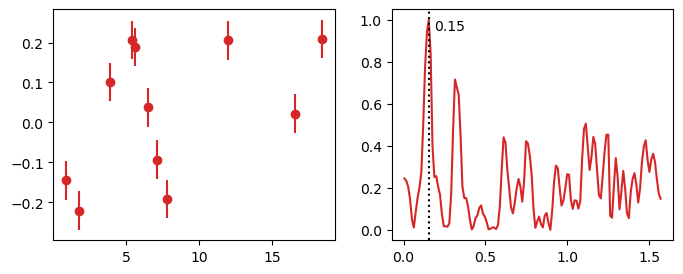

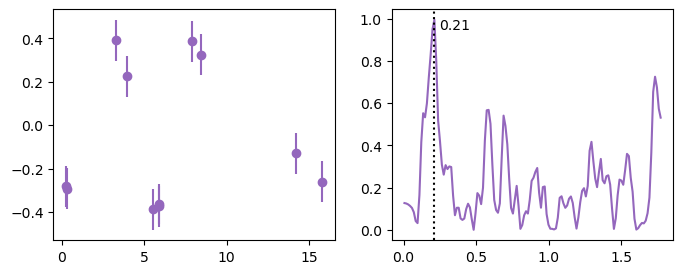

In [46]:
np.random.seed(42)

nobj = 5

P_true = np.random.normal(5,1,nobj)
A_true = np.random.normal(3,1.7,nobj)/10
phi_true = np.random.uniform(0, 2*np.pi, nobj)

t_obs = []
f_obs = []
e_obs = []

for i in range(nobj):
    n = np.random.randint(8,16)

    t = np.random.uniform(0,20,n)
    f = A_true[i]*np.sin(2*np.pi/P_true[i]*t - phi_true[i])
    e = np.std(f)*np.ones(n)/np.sqrt(n)
    
    t_obs.append(t)
    f_obs.append(f)
    e_obs.append(e)
    
    LS = LombScargle(t, f)
    freq, power = LS.autopower()
    
    peak_freq = freq[np.argmax(power)]
    
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    
    ax[0].errorbar(t, f, yerr=e, fmt='o', color=f'C{i}')
    ax[1].plot(freq, power, color=f'C{i}')
    ax[1].axvline(peak_freq, ls=':', color='k')
    ax[1].text(peak_freq+0.03, 0.95, np.round(peak_freq,2))
    plt.show()

In [51]:
t_pred = [None]*ngroups

for i in range(ngroups):
    t_pred[i] = np.linspace(t_obs[i].min(), t_obs[i].max())

In [91]:
with pm.Model() as model:
    # population hyperparameters
    nu_pop_mu = pm.Uniform('nu_pop_mu', lower=0.02, upper=2.0, testval=0.2)
    nu_pop_sd = pm.HalfCauchy('nu_pop_sd', beta=0.1)
    
    A_pop_mu = pm.Uniform('A_pop_mu', lower=0, upper=1, testval=0.4)
    A_pop_sd = pm.HalfCauchy('A_pop_sd', beta=0.1)
    
    # use off-centered parameterization
    # we should really be more careful and provide bounds to prevent nu and A from going negative
    # but let's just cross our fingers and hope things go smoothly
    nu_off = pm.Normal('nu_off', mu=0, sd=1, shape=5)
    A_off = pm.Normal('A_off', mu=0, sd=1, shape=5)

    nu = pm.Deterministic('nu', nu_pop_mu + nu_pop_sd*nu_off)
    A = pm.Deterministic('A', A_pop_mu + A_pop_sd*A_off)
    
    # angles are cyclical, the prior should respect this but we'll ignore this subtlety
    phi = pm.Uniform('phi', lower=0, upper=2*np.pi, shape=5)
    
    # compute model prediction and likelihood
    f_mod = [None]*ngroups
    f_pred = [None]*ngroups
    lnlike = [None]*ngroups
    
    for i in range(ngroups):
        f_mod[i] = pm.Deterministic(f'f_mod_{i}', A[i]*pm.math.sin(2*np.pi*nu[i]*t_obs[i] + phi[i]))
        f_pred[i] = pm.Deterministic(f'f_pred_{i}', A[i]*pm.math.sin(2*np.pi*nu[i]*t_pred[i] + phi[i]))

        lnlike[i] = pm.Normal(f'lnlike_{i}', mu=f_mod[i], sd=e_obs[i], observed=f_obs[i])

In [92]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[A])
    map_soln = pmx.optimize(start=map_soln, vars=[phi])
    trace = pmx.sample(start=map_soln, chains=2, tune=3000, draws=1000, return_inferencedata=True)

optimizing logp for variables: [A_pop_mu, A_pop_sd, A_off]


message: Optimization terminated successfully.
logp: -482.322772575129 -> -86.51889513598348


optimizing logp for variables: [phi]


message: Optimization terminated successfully.
logp: -86.51889513598348 -> -42.36454310856132
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, A_off, nu_off, A_pop_sd, A_pop_mu, nu_pop_sd, nu_pop_mu]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 16 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


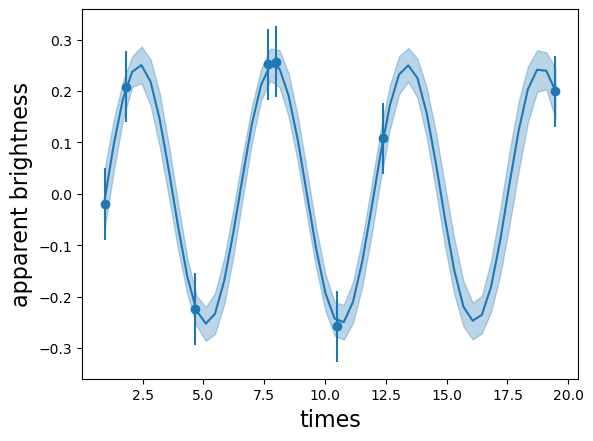

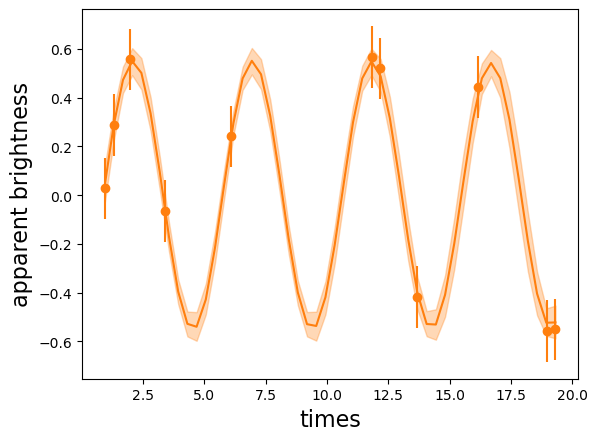

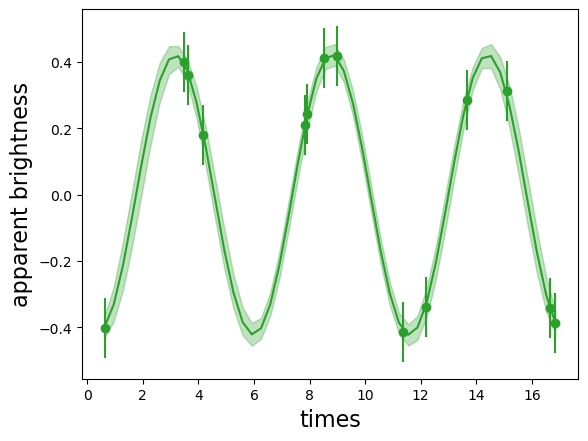

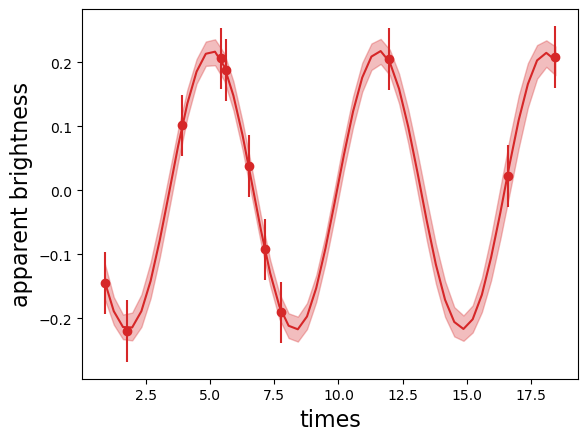

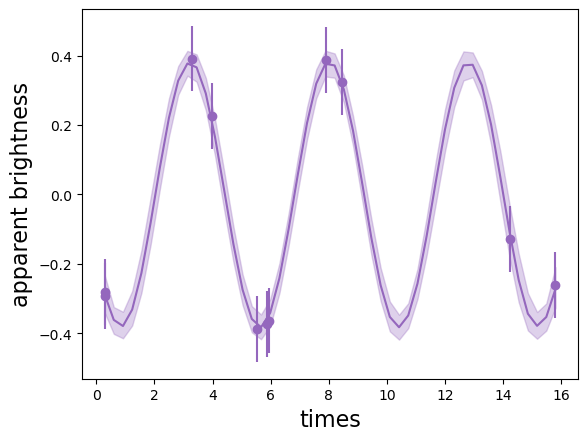

In [93]:
for i in range(ngroups):
    plt.figure()

    t_ = t_pred[i]
    f_ = np.percentile(trace.posterior[f'f_pred_{i}'], [16,50,84], axis=[0,1])
    
    plt.errorbar(t_obs[i], f_obs[i], yerr=e_obs[i], fmt='o', color=f'C{i}')
    plt.plot(t_, f_[1], ls='-', color=f'C{i}')
    plt.fill_between(t_, f_[0], f_[2], color=f'C{i}', alpha=0.3)
    
    plt.xlabel("times", fontsize=16)
    plt.ylabel("apparent brightness", fontsize=16)
    plt.show()

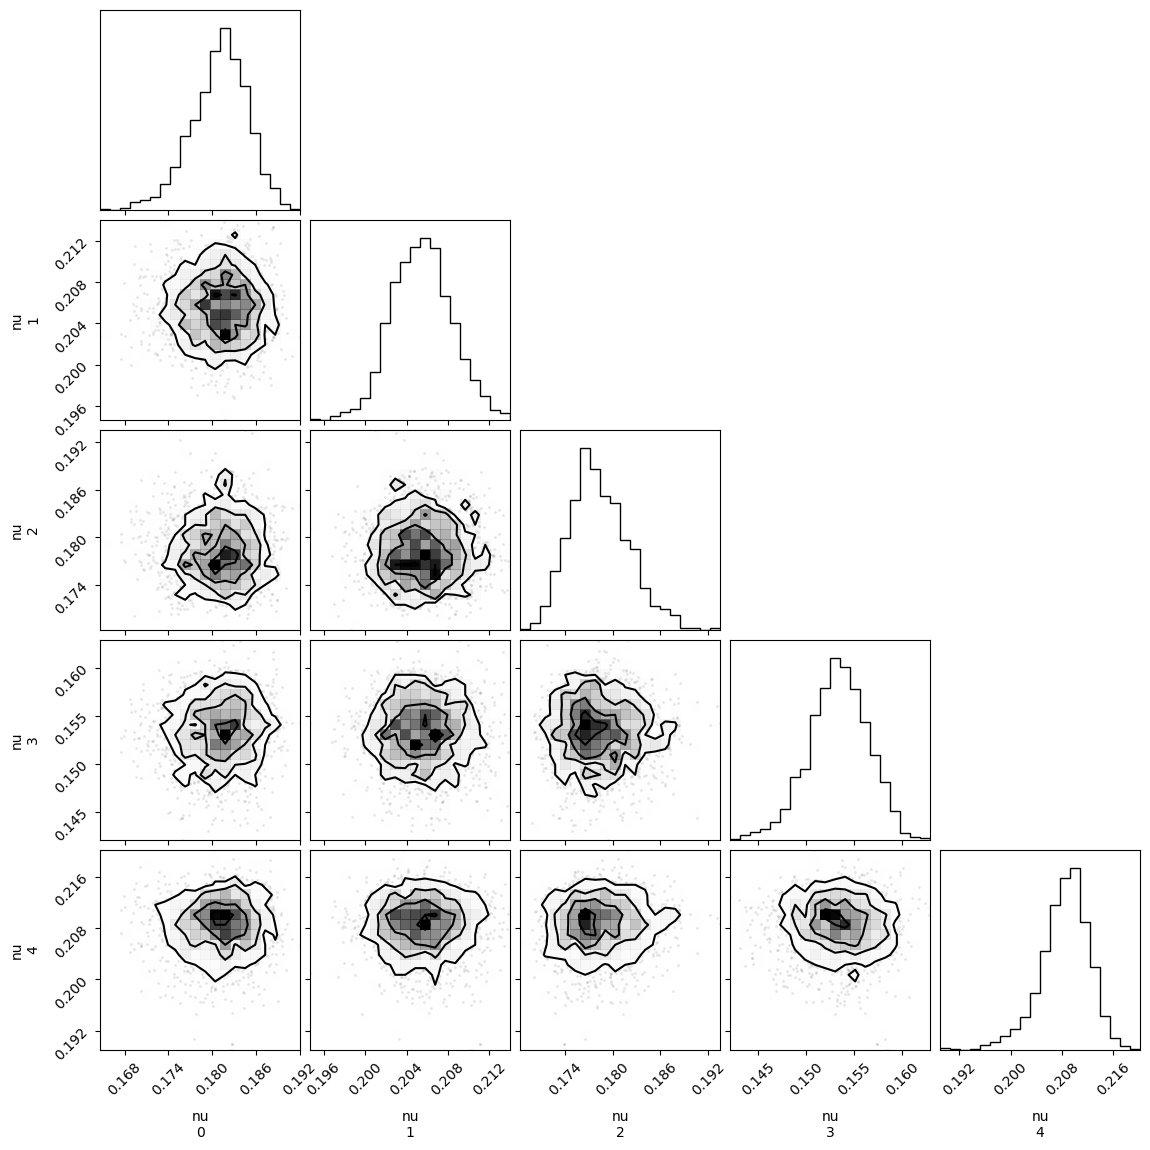

In [94]:
import corner

_ = corner.corner(trace, var_names=['nu'])

In [29]:
import pandas as pd

object_id = []
for i in range(nobj):
    for j in range(len(t_obs[i])):
        object_id.append(labels[i])
        
        
data = {"object_id": object_id,
        "time": np.hstack(t_obs).round(3),
        "flux": np.hstack(f_obs).round(3),
        "flux_err": np.hstack(e_obs).round(3),
       }

data = pd.DataFrame(data)

data.to_csv("dyson_spheres.csv")

In [30]:
data

,object_id,time,flux,flux_err
0,A,10.495,-0.258,0.069
1,A,7.997,0.257,0.069
2,A,0.933,-0.020,0.069
3,A,19.475,0.199,0.069
4,A,4.655,-0.224,0.069
5,A,1.812,0.208,0.069
6,A,12.368,0.108,0.069
7,A,7.649,0.252,0.069
8,B,11.848,0.568,0.126
9,B,0.929,0.027,0.126
